In [2]:
import re
import random
import pandas as pd
import hashlib

In [3]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure VM + Developer,-1966.607644,-98.330382,-35.908797,20
Vocab,-2806.081173,-96.761420,-34.945136,29
PnP PowerShell,-3245.695239,-95.461625,-29.491905,34
Microsoft Purview,-4526.586405,-94.303883,-34.700663,48
Azure Compute Gallery,-1697.363680,-94.297982,-33.583476,18
CCH Axcess,-5314.402393,-91.627627,-34.143682,58
Terraform Codebox,-4062.976506,-86.446309,-34.048496,47
JavaScript Concepts,-4255.776494,-85.115530,-30.536632,50
Power BI,-2697.058258,-84.283071,-39.440099,32
TSQL,-1453.598954,-76.505208,-40.475032,19


# Histogram

sum of ages: ~54784.58


<Axes: >

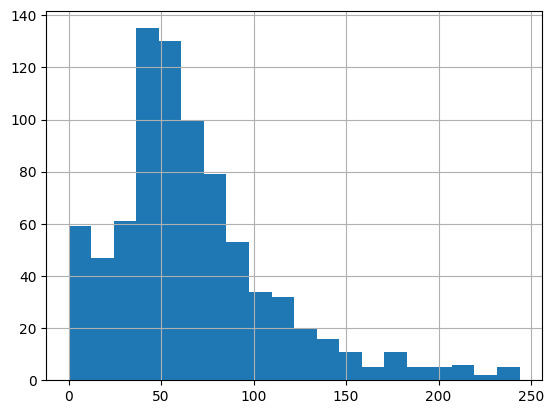

In [6]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~-54784.58


<Axes: >

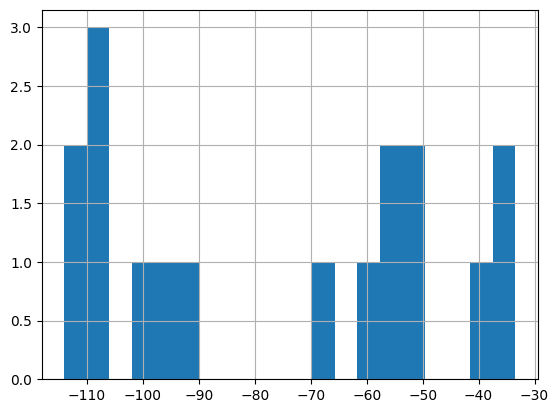

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Asynchronous Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [8]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [9]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [ ]:
n = 3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


## Age Mean

In [ ]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

Cards found: 816
Total card age: 54784.58


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
32,Azure VM + Developer,Language Server Protocol (LSP)\nA communicatio...,78474be23aee1e1a6f611ef57c633fc6,-203.311640,-98.330382,203.311640,1966.607644,0.287030,20,0,0
35,Azure VM + Developer,Cloud-Init\nA Linux-native tool that enables a...,aa7bbfa4657e3078abcc507eb9998a2a,-143.020960,-98.330382,203.311640,1966.607644,0.287030,20,3,0
152,Azure VM + Developer,Availability Zone\nA physically isolated datac...,c6f603bb97a4615946940dbb76721122,-106.291278,-98.330382,203.311640,1966.607644,0.287030,20,6,0
155,Azure VM + Developer,Pre-Commit Hook\nA Git hook that runs scripts ...,f9e3ff658545ba5b4f049cd379d9971f,-88.204380,-98.330382,203.311640,1966.607644,0.287030,20,9,0
265,Azure VM + Developer,VS Code Workspace (.code-workspace)\nA VS Code...,d6d9a8f902e28c32abb08aeabaa29c4f,-82.325732,-98.330382,203.311640,1966.607644,0.287030,20,12,0
361,Azure VM + Developer,Formatter\nA tool that automatically reformats...,47198cd854975ce6917760d7fc32f108,-61.894664,-98.330382,203.311640,1966.607644,0.287030,20,15,0
364,Azure VM + Developer,Systemd Service\nA background service on Linux...,693a27f446083929a9eee1925be36c78,-41.879139,-98.330382,203.311640,1966.607644,0.287030,20,18,0
57,Vocab,"Well of Lost Plots, Fforde\nReigate\nnoun | RY...",ea7311db7ab366d8a04c166f79592837,-223.136543,-96.761420,223.136543,2806.081173,0.210623,29,0,0
60,Vocab,"Something Rotten, Fforde\nBarnaby Rudge\nnoun ...",f6ca4f0592f49feb7223298c0e7b428a,-181.577173,-96.761420,223.136543,2806.081173,0.210623,29,3,0
177,Vocab,"Jingo, Pratchett\nRotas\nnoun (plural) | ROH-t...",2962ebeb526e550908aa4da49c684448,-120.979245,-96.761420,223.136543,2806.081173,0.210623,29,6,0


## Age Max

In [12]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [13]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [14]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [15]:
existing_cards.head(10)['age'].sum()

np.float64(-1252.6207548289883)

In [16]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
67,PnP PowerShell,App-Only Authentication\nA mode where applicat...,12d9bc97a1e6f53d3b7295eb85274bad,-243.814455,-95.461625,243.814455,3245.695239,0.459078,34,0,0
87,Terraform Codebox,A cloud-init.yaml.tpl file is a template for p...,e86be4b765ffee839b385a1a96ac3db1,-241.166068,-86.446309,241.166068,4062.976506,0.397479,47,0,0
62,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,-234.991902,-84.283071,234.991902,2697.058258,0.260104,32,0,0
103,CCH Axcess,Enable AutoText descriptions\nAllows you to cr...,5d78f7e45fe2c0dbf42b9c87b93c2224,-234.613603,-91.627627,234.613603,5314.402393,0.167845,58,0,0
102,CCH Axcess,Security groups with any level of rights can b...,78f3ef96be8d308e501c9a70a0bc0c56,-232.284037,-91.627627,234.613603,5314.402393,0.167845,58,1,1
57,Vocab,"Well of Lost Plots, Fforde\nReigate\nnoun | RY...",ea7311db7ab366d8a04c166f79592837,-223.136543,-96.761420,223.136543,2806.081173,0.210623,29,0,0
88,Terraform Codebox,Azure Files can be used to persist your coding...,9775a34a34e3610d8ddc43c1e0b44268,-223.059591,-86.446309,241.166068,4062.976506,0.397479,47,1,1
107,Python,Q:\nWhat method do you call to parse the comma...,58c3e5284b8e017e25b1fe16b13cb52b,-218.062317,-54.169414,218.062317,4550.230738,0.992248,84,0,0
69,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,-217.602331,-95.461625,243.814455,3245.695239,0.459078,34,1,1
22,Azure Compute Gallery,"Managed Image – A single, region-bound image s...",4099811ce9ab63014bfbe9d3999b3e32,-214.856102,-94.297982,214.856102,1697.363680,0.997474,18,0,0


In [17]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 67.138'